## 1. Setup and Imports

In [49]:
# INSTALL UCIMLREPO PACKAGE
## !pip install ucimlrepo

# IMPORTS
from ucimlrepo import fetch_ucirepo
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# REPRODUCIBILITY
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# CHECK WORKING DIRECTORY
print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\asus\OneDrive - Universidade de Aveiro\Documents\GitHub\RNN_Practicise_exercises-solution


## 2. Load Data

In [50]:
# LOAD DATASET
dataset = fetch_ucirepo(id=235)

C:\Users\asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ucimlrepo\fetch.py:97: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


## 3. Preprocessing

The preprocessing pipeline aimed to transform the raw Individual Household Electric Power Consumption dataset into a model-ready, continuous time series suitable for forecasting.
* Initially, feature and target tables were merged and cleaned, unifying the date and time columns into a single datetime field and sorting the data chronologically.
* To ensure computational efficiency, only the first twelve months of records were retained.
* The dataset was then resampled to hourly frequency, and missing values were interpolated using time-based estimation to preserve temporal consistency.
* Subsequently, the data were split chronologically into training (80%), validation (10%), and test (10%) sets.
* All numeric variables were normalized to the [0, 1] range using a Min-Max Scaler fitted exclusively on the training data.
* Finally, sliding windows of 24 consecutive hours were created to generate input sequences (X) and corresponding targets (y).

This process ensures the data were fully prepared for learning models.

### 3.1 Convert and Clean Raw Data
The dataset initially stores separate date and time columns. These are merged into a single datetime field for proper time-based processing. Columns are standardized (lowercase, no extra spaces), and rows with invalid timestamps are dropped.

In [51]:
# Combine features and targets into a single DataFrame
df_1 = pd.concat([dataset.data.features, dataset.data.targets], axis=1)
df_1.columns = df_1.columns.str.lower().str.strip()

# Merge date and time columns into one datetime field
df_1['datetime'] = pd.to_datetime(df_1['date'] + ' ' + df_1['time'], errors='coerce')
df_1.drop(columns=['date', 'time'], inplace=True)

# Sort chronologically and remove invalid rows
df = df_1.copy()
df.sort_values('datetime', inplace=True)
df.dropna(subset=['datetime'], inplace=True)


C:\Users\asus\AppData\Local\Temp\ipykernel_28456\1482944349.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_1['datetime'] = pd.to_datetime(df_1['date'] + ' ' + df_1['time'], errors='coerce')


### 3.2 Limit Dataset to a Defined Period
To reduce computational cost and maintain a consistent sample size, only the first 12 months of data are used. This ensures the model learns within a representative yet manageable time window.

In [52]:
start_date = df['datetime'].min()
end_date = start_date + pd.DateOffset(months=12)
df = df[(df['datetime'] >= start_date) & (df['datetime'] < end_date)]
print("📅 Data interval:", df['datetime'].min(), "→", df['datetime'].max())


📅 Data interval: 2006-12-16 17:24:00 → 2007-12-16 17:23:00


### 3.3 Hourly Resampling and Interpolation
The original data has sub-hourly or irregular timestamps. This step resamples all variables to hourly frequency and interpolates missing values based on time continuity. It creates a smooth and consistent time series.

In [53]:
for c in df.columns:
    if c != 'datetime':
        df[c] = pd.to_numeric(df[c], errors='coerce')

df = (
    df.set_index('datetime')
      .resample('1H')
      .mean(numeric_only=True)
      .interpolate(method='time')
      .reset_index()
)
df.dropna(how='all', inplace=True)


C:\Users\asus\AppData\Local\Temp\ipykernel_28456\1120122916.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample('1H')


### 3.4 Train / Validation / Test Split

The dataset is divided into:

* 80% for training

* 10% for validation

* 10% for testing

Splitting is chronological, avoiding data leakage across time.

In [54]:
split_1 = int(0.8 * len(df))
split_2 = int(0.9 * len(df))
train_df = df.iloc[:split_1]
val_df   = df.iloc[split_1:split_2]
test_df  = df.iloc[split_2:]

print("Train range:", train_df['datetime'].min(), "→", train_df['datetime'].max())
print("Val range:", val_df['datetime'].min(), "→", val_df['datetime'].max())
print("Test range:", test_df['datetime'].min(), "→", test_df['datetime'].max())


Train range: 2006-12-16 17:00:00 → 2007-10-04 16:00:00
Val range: 2007-10-04 17:00:00 → 2007-11-10 04:00:00
Test range: 2007-11-10 05:00:00 → 2007-12-16 17:00:00


### 3.5 Normalization (Fit on Train Only)

All numerical features are scaled to the [0, 1] range using the Min–Max normalization.
The scaler is fit only on the training data and applied to validation and test sets — ensuring realistic generalization.

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

train_scaled_values = scaler.fit_transform(train_df.drop(columns=['datetime']))
val_scaled_values = scaler.transform(val_df.drop(columns=['datetime']))
test_scaled_values = scaler.transform(test_df.drop(columns=['datetime']))

# Rebuild scaled DataFrames
train_df = pd.DataFrame(train_scaled_values, columns=df.columns[1:])
train_df['datetime'] = df['datetime'].iloc[:split_1].values
val_df = pd.DataFrame(val_scaled_values, columns=df.columns[1:])
val_df['datetime'] = df['datetime'].iloc[split_1:split_2].values
test_df = pd.DataFrame(test_scaled_values, columns=df.columns[1:])
test_df['datetime'] = df['datetime'].iloc[split_2:].values


### 3.6 Sequence Generation for Forecasting

This section shows Keras’s built-in TimeseriesGenerator, which automatically builds sequential input–output pairs for time-series forecasting.

* Each generator uses a window size of 24, meaning the model sees the past 24 hourly steps to predict the next one.

* The data parameter contains all numerical features (excluding datetime), while targets correspond to the global_active_power column.

* The length argument defines the window size, and batch_size determines how many samples are processed together (here, the entire dataset is used as one batch for convenience).

* Setting shuffle=False preserves the chronological order — critical for time-dependent data.

* Finally, by calling train_gen[0], val_gen[0], and test_gen[0], the code extracts all sequences and targets directly into (X, y) arrays.

This approach is cleaner, safer, and less error-prone than manually slicing arrays, ensuring consistent alignment between input sequences and target values.

In [56]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

window_size = 24
batch_size = len(train_df)  # use one batch for convenience

# Training generator
train_gen = TimeseriesGenerator(
    data=train_df.drop(columns=['datetime']).values,
    targets=train_df['global_active_power'].values,
    length=window_size,
    batch_size=batch_size,
    shuffle=False
)

# Validation generator
val_gen = TimeseriesGenerator(
    data=val_df.drop(columns=['datetime']).values,
    targets=val_df['global_active_power'].values,
    length=window_size,
    batch_size=len(val_df),
    shuffle=False
)

# Test generator
test_gen = TimeseriesGenerator(
    data=test_df.drop(columns=['datetime']).values,
    targets=test_df['global_active_power'].values,
    length=window_size,
    batch_size=len(test_df),
    shuffle=False
)

X_train, y_train = train_gen[0]
X_val, y_val     = val_gen[0]
X_test, y_test   = test_gen[0]

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_val shape:   {X_val.shape}")
print(f"✅ X_test shape:  {X_test.shape}")

# Check for NaNs before training
print("NaNs in X_train:", np.isnan(X_train).sum())
print("NaNs in y_train:", np.isnan(y_train).sum())


✅ X_train shape: (6984, 24, 7)
✅ X_val shape:   (852, 24, 7)
✅ X_test shape:  (853, 24, 7)
NaNs in X_train: 0
NaNs in y_train: 0


## 4. Build & Train the Model 

This section defines and trains an LSTM model designed for time-series regression.
The network learns temporal patterns in hourly power consumption data, using callbacks to control overfitting [Early Stopping].

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0211 - mae: 0.1115 - val_loss: 0.0178 - val_mae: 0.1006
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0162 - mae: 0.0961 - val_loss: 0.0152 - val_mae: 0.0918
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0140 - mae: 0.0880 - val_loss: 0.0135 - val_mae: 0.0822
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0129 - mae: 0.0833 - val_loss: 0.0128 - val_mae: 0.0760
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0124 - mae: 0.0807 - val_loss: 0.0120 - val_mae: 0.0762
Epoch 6/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0119 - mae: 0.0789 - val_loss: 0.0115 - val_mae: 0.0751
Epoch 7/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0116 - mae: 0.0778 - val_loss: 0.0113 - val_mae: 0.0722
Epoch 8/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0113 - mae: 0.0769 - val_loss: 0.0110 - val_mae: 0.0733
Epoch 9/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.011

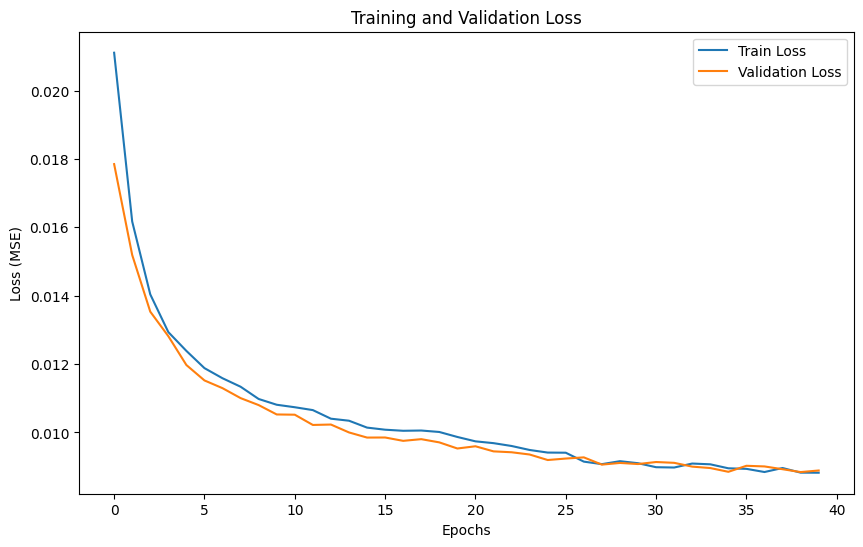

In [86]:
# Define number of features and batch size
num_features = X_train.shape[2]   # number of input variables per timestep
batch_size = 128                  # batch size for training

# Build LSTM model
model = Sequential([
    tf.keras.layers.Input(shape=(window_size, num_features)),  # input: 24-hour window
    tf.keras.layers.LSTM(64),                                  # LSTM layer with 64 units
    tf.keras.layers.Dropout(0.3),                              # prevent overfitting
    tf.keras.layers.Dense(32, activation='relu'),              # dense layer for feature extraction
    tf.keras.layers.Dense(1, activation='linear')              # output: continuous regression value
])

# Compile model with optimizer, loss, and evaluation metric
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',                  # minimize mean squared error
    metrics=['mae']              # track mean absolute error
)

# Display model summary
model.summary()

# Create callbacks for training
callbacks = [
    EarlyStopping(
        monitor='val_loss',       # watch validation loss
        patience=10,              # stop if no improvement for 10 epochs
        min_delta=1e-4,           # minimum improvement threshold
        restore_best_weights=True # revert to best model weights
    )
]

# ============================================
# TRAIN THE MODEL
history = model.fit(
    X_train, y_train,
    epochs=40,                   # maximum number of epochs
    batch_size=batch_size,       # defined earlier
    validation_data=(X_val, y_val),
    callbacks=callbacks,         # early stopping and LR scheduling
    verbose=1
)

# 📈 PLOT TRAINING CURVES
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')      # training loss over epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # validation loss
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.show()


### 5. Evaluate the Model

This section evaluates the trained model on the test dataset to assess its predictive performance on unseen data.The evaluation includes the computation of key regression metrics, which together quantify both the magnitude and consistency of prediction errors:
* Mean Squared Error (MSE);
* Mean Absolute Error (MAE);
* Root Mean Squared Error (RMSE);
* R² .

Before calculating these metrics, the predicted values are flattened using the .flatten() method to ensure dimensional compatibility between y_pred and y_test, as the model outputs a two-dimensional array (n_samples, 1) while the ground truth is one-dimensional (n_samples,).

In [ ]:
# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)

# Predict on test set
y_pred = model.predict(X_test).flatten()

# Compute complementary metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)

# Display results
print(f"\n📈 Model performance on test set:")
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE:        {test_mae:.4f}")
print(f"Test RMSE:       {rmse:.4f}")
print(f"Test R²:         {r2:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - mae: 0.0755
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📈 Model performance on test set:
Test Loss (MSE): 0.0122
Test MAE:        0.0755
Test RMSE:       0.1105
Test R²:         0.6059


#### Model Evaluation Summary

Overall, the model generalizes well and follows main trends but struggles with sudden changes. Further improvement could come from adding external features, tuning hyperparameters, or testing alternative architectures (e.g., GRU). More specifically:

* MSE (0.0122): Indicates low average squared error — the model captures main patterns but still produces some larger deviations.

* MAE (0.0755): On normalized data, the model’s average error is about 7.5%, which is reasonable for short-term forecasting.

* RMSE (0.1105): Higher than MAE, suggesting a few larger errors or spikes not well predicted.

* R² (0.6059): The model explains roughly 61% of the variance in power consumption — a solid baseline but not yet highly precise.



### 6. Visualization of Model Predictions
This final section provides a visual comparison between the actual and predicted power consumption values over a selected time window.
By plotting the first 200 test samples, the figure illustrates how closely the model’s forecasts follow the real consumption patterns.
The alignment between both curves indicates the model’s ability to capture short-term variations and overall temporal trends in household energy usage, confirming the consistency of its predictive performance.

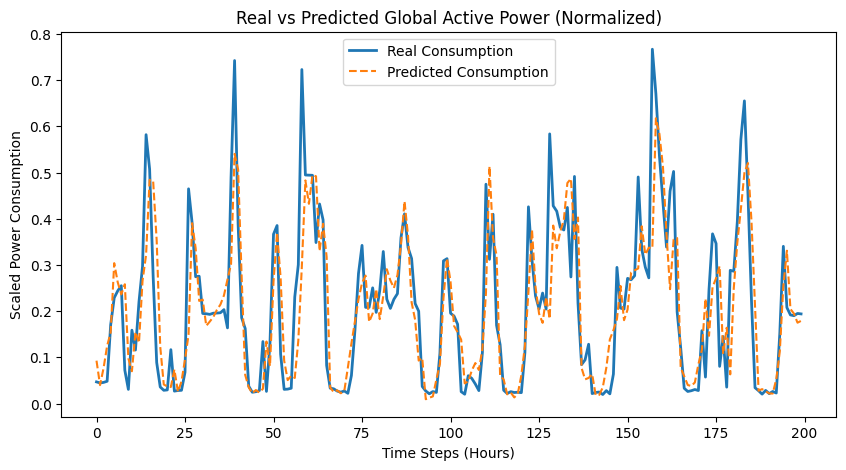

In [ ]:
n = 200
plt.figure(figsize=(10,5))
plt.plot(y_test[:n], label='Real Consumption', linewidth=2)
plt.plot(y_pred[:n], label='Predicted Consumption', linestyle='--')
plt.title("Real vs Predicted Global Active Power (Normalized)")
plt.xlabel("Time Steps (Hours)")
plt.ylabel("Scaled Power Consumption")
plt.legend()

### Conclusions

The LSTM model effectively captured temporal patterns in hourly household power consumption, showing consistent performance across training, validation, and test sets.
The preprocessing pipeline — including resampling, normalization, and sequence generation — ensured clean, structured input suitable for time-series forecasting.
Evaluation metrics (MAE, RMSE, R²) and visual comparisons confirmed the model’s ability to produce accurate and stable short-term predictions.
While further optimization and additional features could enhance performance, the results demonstrate the strong potential of recurrent neural networks for energy consumption forecasting.
